<a href="https://colab.research.google.com/github/naharluna/Birds-Species-Classification/blob/main/Cancer_Detection_using_DenseNet121_%2B_Swin_Tiny_%2B_fine_grained_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build a hybrid model with DenseNet121 + Swin-Tiny + fine grained attention layer.

In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n/lungn691.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n/lungn3098.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n/lungn4225.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n/lungn40.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n/lungn4213.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n/lungn4645.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n/lungn3468.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n/lungn38

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/lung-and-colon-cancer-histopathological-images")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'lung-and-colon-cancer-histopathological-images' dataset.
Path to dataset files: /kaggle/input/lung-and-colon-cancer-histopathological-images


In [ ]:
import os

# Use the path from the output of the previous cell
base_dir = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/"

paths = {
    "colon_aca": os.path.join(base_dir, "colon_image_sets/colon_aca"),
    "colon_n": os.path.join(base_dir, "colon_image_sets/colon_n"),
    "lung_aca": os.path.join(base_dir, "lung_image_sets/lung_aca"),
    "lung_scc": os.path.join(base_dir, "lung_image_sets/lung_scc"),
    "lung_n": os.path.join(base_dir, "lung_image_sets/lung_n")
}

image_paths = []
labels = []

for label, path in paths.items():
    for filename in os.listdir(path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(path, filename))
            labels.append(label)

df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

In [ ]:
df.head()

image_path      label
0  /kaggle/input/lung-and-colon-cancer-histopatho...  colon_aca
1  /kaggle/input/lung-and-colon-cancer-histopatho...  colon_aca
2  /kaggle/input/lung-and-colon-cancer-histopatho...  colon_aca
3  /kaggle/input/lung-and-colon-cancer-histopatho...  colon_aca
4  /kaggle/input/lung-and-colon-cancer-histopatho...  colon_aca

In [ ]:
df.tail()

image_path   label
24995  /kaggle/input/lung-and-colon-cancer-histopatho...  lung_n
24996  /kaggle/input/lung-and-colon-cancer-histopatho...  lung_n
24997  /kaggle/input/lung-and-colon-cancer-histopatho...  lung_n
24998  /kaggle/input/lung-and-colon-cancer-histopatho...  lung_n
24999  /kaggle/input/lung-and-colon-cancer-histopatho...  lung_n

In [ ]:
df.shape

(25000, 2)

In [ ]:
df.columns

Index(['image_path', 'label'], dtype='object')

In [ ]:
df.isnull().sum()

image_path    0
label         0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  25000 non-null  object
 1   label       25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [ ]:
df['label'].unique()

array(['colon_aca', 'colon_n', 'lung_aca', 'lung_scc', 'lung_n'],
      dtype=object)

In [ ]:
df['label'].value_counts()

label
colon_aca    5000
colon_n      5000
lung_aca     5000
lung_scc     5000
lung_n       5000
Name: count, dtype: int64

In [ ]:
import os, math, random
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


/tmp/ipython-input-3034526061.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="pastel", ax=ax)


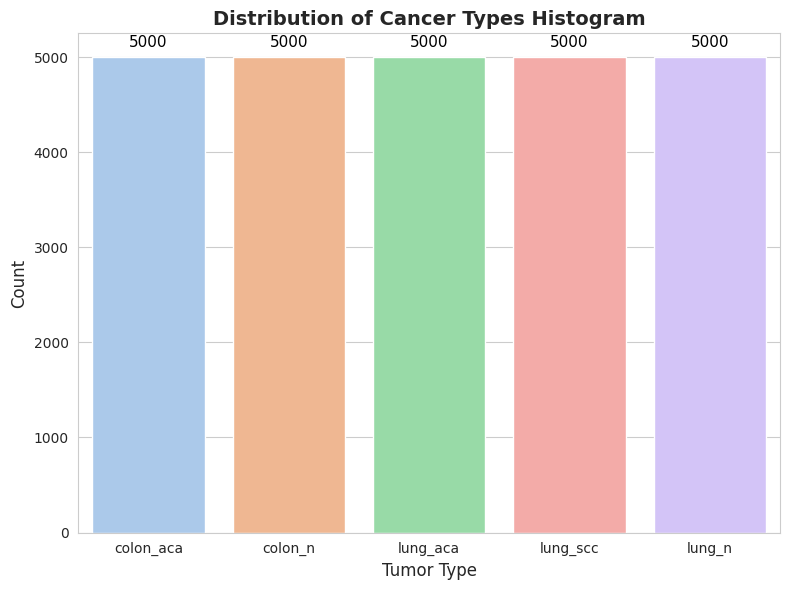

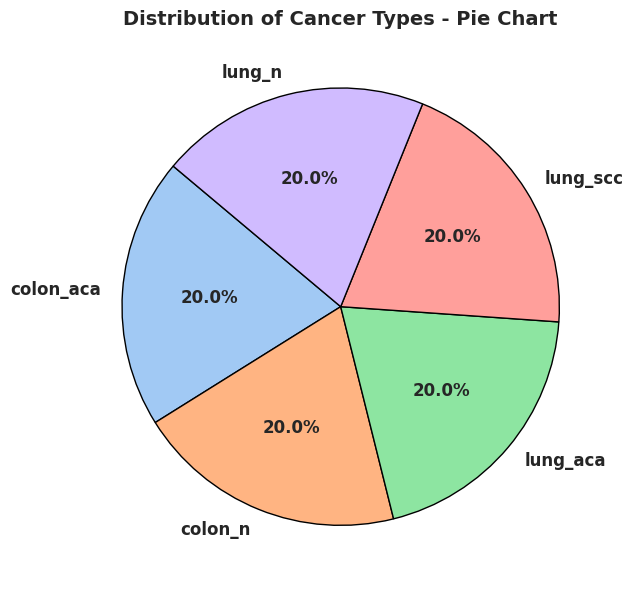

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use a soothing pastel palette
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="pastel", ax=ax)

ax.set_title("Distribution of Cancer Types Histogram", fontsize=14, fontweight='bold')
ax.set_xlabel("Tumor Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

# Pie chart with soothing pastel tones
label_counts = df["label"].value_counts()

fig, ax = plt.subplots(figsize=(8, 6))
colors = sns.color_palette("pastel", len(label_counts))

ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%',
       startangle=140, colors=colors, textprops={'fontsize': 12, 'weight': 'bold'},
       wedgeprops={'edgecolor': 'black', 'linewidth': 1})

ax.set_title("Distribution of Cancer Types - Pie Chart", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
# df: columns = ['image_path', 'label']  (তোমার আগের Cell থেকে আসবে)
assert {'image_path','label'}.issubset(df.columns)

# Train/Temp (val+test)
df_train, df_temp = train_test_split(
    df, test_size=0.20, stratify=df['label'], random_state=42
)
# Val/Test
df_val, df_test = train_test_split(
    df_temp, test_size=0.50, stratify=df_temp['label'], random_state=42
)

print(f"Train: {len(df_train)} | Val: {len(df_val)} | Test: {len(df_test)}")
df_train.head(2)


Train: 20000 | Val: 2500 | Test: 2500


image_path    label
6495   /kaggle/input/lung-and-colon-cancer-histopatho...  colon_n
21818  /kaggle/input/lung-and-colon-cancer-histopatho...   lung_n

In [ ]:
# পুরো train split থেকে প্রতিটি চ্যানেলের mean/std (Resize+ToTensor-এর পরে)
from PIL import Image
import torch
from torchvision import transforms
from tqdm.auto import tqdm

IMG_SIZE_FOR_STATS = 224  # ট্রেনিং সাইজের সাথে মিল রাখাই ভালো
stats_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE_FOR_STATS, IMG_SIZE_FOR_STATS)),
    transforms.ToTensor(),  # [C,H,W] in [0,1]
])

sum_c = torch.zeros(3)
sumsq_c = torch.zeros(3)
num_pixels_total = 0

for p in tqdm(df_train['image_path'].tolist(), desc="Computing mean/std (full train)"):
    img = Image.open(p).convert('RGB')
    t = stats_tf(img)  # [3,H,W]
    c, h, w = t.shape
    num_pixels_total += (h * w)
    sum_c += t.view(3, -1).sum(dim=1)
    sumsq_c += (t.view(3, -1) ** 2).sum(dim=1)

MEAN = (sum_c / num_pixels_total).tolist()
VAR  = (sumsq_c / num_pixels_total - torch.tensor(MEAN) ** 2)
STD  = VAR.clamp_min(1e-12).sqrt().tolist()

print("Dataset MEAN (full train):", MEAN)
print("Dataset STD  (full train):", STD)


Computing mean/std (full train):   0%|          | 0/20000 [00:00<?, ?it/s]

Dataset MEAN (full train): [0.7283011078834534, 0.5991580486297607, 0.8758725523948669]
Dataset STD  (full train): [0.17529161274433136, 0.20959845185279846, 0.09710139036178589]


In [ ]:
from torchvision import transforms

IMG_SIZE = 224  # চাইলে এখানে টিউন করবে

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

test_tf = val_tf


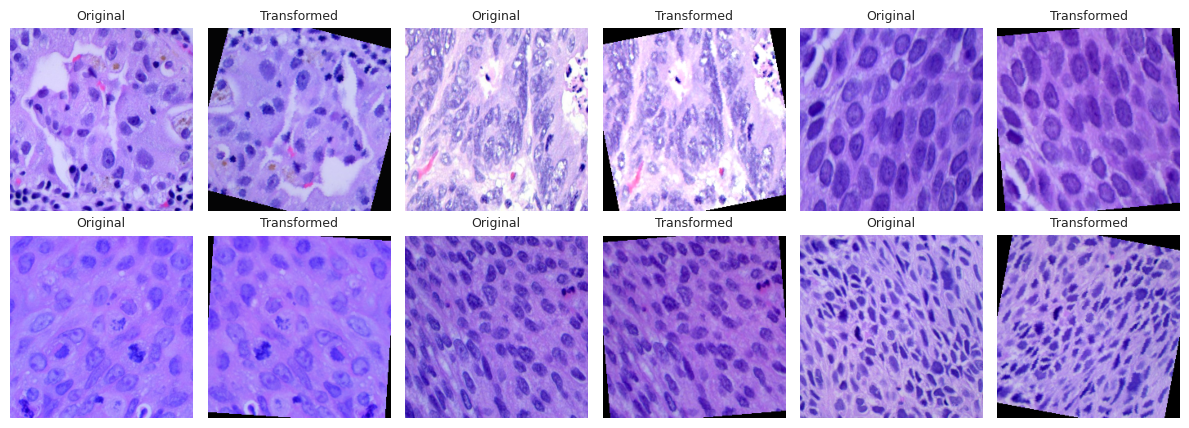

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

# ডি-নরমালাইজার (দেখানোর সুবিধার জন্য)
inv_mean = torch.tensor(MEAN).view(3,1,1)
inv_std  = torch.tensor(STD).view(3,1,1)
def denorm(x: torch.Tensor):
    return (x * inv_std + inv_mean).clamp(0,1)

def show_before_after(df_subset, n=6, tf=train_tf, seed=42):
    rng = np.random.RandomState(seed)
    idxs = rng.choice(len(df_subset), size=min(n, len(df_subset)), replace=False)

    rows = math.ceil(n / 3)
    plt.figure(figsize=(12, 2.2*rows))
    for i, ix in enumerate(idxs, 1):
        p = df_subset.iloc[ix]['image_path']
        img = Image.open(p).convert('RGB')

        x_orig = np.array(img)
        x_aug  = tf(img)
        x_aug  = (denorm(x_aug).permute(1,2,0).numpy() * 255).astype(np.uint8)

        plt.subplot(rows, 6, 2*i-1); plt.imshow(x_orig); plt.title("Original", fontsize=9); plt.axis('off')
        plt.subplot(rows, 6, 2*i);   plt.imshow(x_aug);  plt.title("Transformed", fontsize=9); plt.axis('off')

    plt.tight_layout(); plt.show()

show_before_after(df_train, n=6, tf=train_tf, seed=7)


In [ ]:
from torch.utils.data import Dataset, DataLoader

class HistopathDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.classes = sorted(self.df['label'].unique())
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert('RGB')
        if self.transform: img = self.transform(img)
        y = self.class_to_idx[row['label']]
        return img, y

train_set = HistopathDataset(df_train, transform=train_tf)
val_set   = HistopathDataset(df_val,   transform=val_tf)
test_set  = HistopathDataset(df_test,  transform=test_tf)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

xb, yb = next(iter(train_loader))
print("Train batch:", xb.shape, yb.shape)
print("Classes:", train_set.classes)


Train batch: torch.Size([32, 3, 224, 224]) torch.Size([32])
Classes: ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


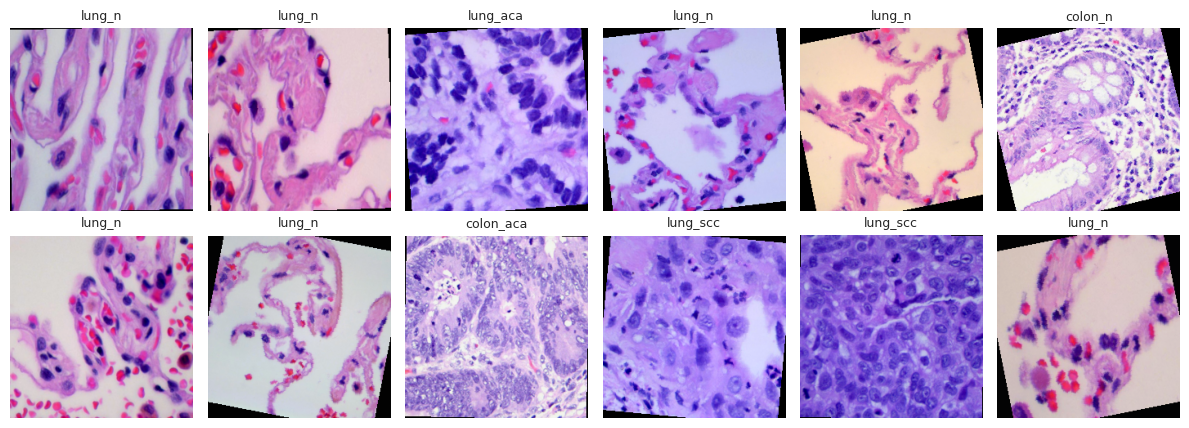

In [ ]:
def show_batch(xb, yb, classes, max_images=12):
    n = min(max_images, xb.size(0))
    cols = 6
    rows = math.ceil(n / cols)
    plt.figure(figsize=(12, 2.2*rows))
    for i in range(n):
        img = denorm(xb[i]).permute(1,2,0).numpy()
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(classes[yb[i].item()], fontsize=9)
        plt.axis('off')
    plt.tight_layout(); plt.show()

show_batch(xb, yb, train_set.classes, max_images=12)


In [ ]:
# Kill old big objects & free VRAM (run this once before training)
import gc, torch, os
for n in ["model","optimizer","scheduler","criterion","train_loader","val_loader","test_loader","scaler"]:
    if n in globals():
        try: del globals()[n]
        except: pass
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
print("GPU cache cleared.")

GPU cache cleared.


# Build a hybrid model with DenseNet121 + Swin-Tiny + fine grained attention layer.

In [ ]:
!pip install timm
# Check if torch and torchvision are installed (they usually are in Kaggle environments)
try:
    import torch
    import torchvision
    print("torch and torchvision are already installed.")
except ImportError:
    print("torch or torchvision not found. Please ensure they are installed.")


torch and torchvision are already installed.


## Define the hybrid model architecture




In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm

class FineGrainedAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 2, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels // 2, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attention_map = self.sigmoid(self.conv2(self.relu(self.conv1(x))))
        return x * attention_map

class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Load pre-trained DenseNet121 and remove the classifier
        self.densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        self.densenet.classifier = nn.Identity() # Remove the final classification layer

        # Load pre-trained Swin-Tiny and remove the head
        # Correcting the model name by removing the invalid tag
        self.swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)
        self.swin.head = nn.Identity() # Remove the final classification layer

        # Define layers to handle feature extraction and fusion
        # DenseNet121 output before final pool is 1024 channels. Spatial size varies.
        self.densenet_features = nn.Sequential(*list(self.densenet.features.children()))

        # Swin outputs features of shape (B, N, C), where N is number of tokens, C is channels (768).
        # We need to reshape this to (B, C, H, W).
        self.swin_features = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=0) # Output features before head

        # Use AdaptiveAvgPool2d to get fixed spatial size features from DenseNet
        self.densenet_pool = nn.AdaptiveAvgPool2d((7, 7)) # Pool DenseNet features to 7x7

        # Swin features are (B, 768, 56, 56) for 224 input. Pool to 7x7 as well.
        self.swin_pool = nn.AdaptiveAvgPool2d((7, 7))

        # After pooling to 7x7, DenseNet features are (B, 1024, 7, 7), Swin features are (B, 768, 7, 7).
        # Concatenate along the channel dimension: (B, 1024+768, 7, 7) = (B, 1792, 7, 7).
        fused_channels = 1024 + 768 # Total channels after concatenation

        # Define the fine-grained attention layer on the fused features
        self.attention = FineGrainedAttention(in_channels=fused_channels)

        # Define the classification head
        # After attention, features are still (B, 1792, 7, 7).
        # Apply Global Average Pooling to get (B, 1792).
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(fused_channels, 512), # Input features after GAP and attention
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        # Freeze pre-trained weights initially
        for param in self.densenet.parameters():
            param.requires_grad = False
        for param in self.swin.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Extract features from DenseNet
        densenet_ft = self.densenet_features(x) # Output is (B, 1024, H', W')
        densenet_pooled = self.densenet_pool(densenet_ft) # Output is (B, 1024, 7, 7)

        # Extract features from Swin
        swin_ft = self.swin_features(x) # Output is (B, N, 768) for Swin
        # Reshape Swin features to spatial
        batch_size, num_tokens, channels = swin_ft.shape
        # Assuming input size 224, patch size 4, spatial size before flattening is 224/4 = 56
        spatial_size = int(num_tokens**0.5)
        swin_spatial = swin_ft.view(batch_size, spatial_size, spatial_size, channels).permute(0, 3, 1, 2) # (B, 768, 56, 56)

        swin_pooled = self.swin_pool(swin_spatial) # Output is (B, 768, 7, 7)


        # Combine features (concatenation)
        fused_features = torch.cat([densenet_pooled, swin_pooled], dim=1) # (B, 1792, 7, 7)

        # Apply fine-grained attention
        attended_features = self.attention(fused_features) # (B, 1792, 7, 7)

        # Global Average Pooling
        pooled_attended_features = self.global_avg_pool(attended_features).squeeze(-1).squeeze(-1) # (B, 1792)

        # Classification head
        output = self.classifier(pooled_attended_features)

        return output

# Example usage (assuming you have the number of classes defined)
num_classes = len(df['label'].unique()) # Assuming df is available from previous cells
model = HybridModel(num_classes)

# Print the model architecture (optional)
# print(model)

# Verify freezing (optional)
# for name, param in model.named_parameters():
#     if 'densenet' in name or 'swin' in name:
# #         print(f'{name}: requires_grad={param.requires_grad}')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 1. Define the loss function suitable for multi-class classification.
criterion = nn.CrossEntropyLoss()

# 2. Define the optimizer for updating the model's weights.
# We will initially unfreeze only the classifier and attention layers,
# and potentially the later layers of the pre-trained models later.
# For now, only train the head and attention layers.
params_to_update = []
for name, param in model.named_parameters():
    if 'classifier' in name or 'attention' in name:
        param.requires_grad = True
        params_to_update.append(param)
        # print(f"Training: {name}")
    else:
        param.requires_grad = False # Ensure other layers are frozen

optimizer = optim.AdamW(params_to_update, lr=1e-4) # AdamW is a good general choice

# 3. Check for GPU availability and move the model to the appropriate device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

# 4. Implement an early stopping mechanism to prevent overfitting.
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            # if self.verbose:
            #     print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        # if self.verbose:
        #     print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

early_stopping = EarlyStopping(patience=10, verbose=True) # Adjust patience as needed

# 5. Implement a learning rate scheduler to adjust the learning rate during training.
# Reduce learning rate when validation loss stops improving
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5) # Removed verbose=True

Using device: cuda


In [ ]:
from tqdm.auto import tqdm
import torch
from sklearn.metrics import accuracy_score

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    all_labels = []
    all_preds = []

    # Use tqdm for a progress bar
    for inputs, labels in tqdm(train_loader, desc="Training Epoch"):
        # Move data to the specified device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss and predictions
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc

def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    all_labels = []
    all_preds = []

    # Disable gradient calculation
    with torch.no_grad():
        # Use tqdm for a progress bar
        for inputs, labels in tqdm(val_loader, desc="Evaluating Model"):
            # Move data to the specified device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate loss and predictions
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim


class FineGrainedAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 2, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels // 2, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attention_map = self.sigmoid(self.conv2(self.relu(self.conv1(x))))
        return x * attention_map

class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Load pre-trained DenseNet121 and remove the classifier
        self.densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        # Keep the features part, remove the classifier
        self.densenet_features = nn.Sequential(*list(self.densenet.features.children()))

        # Load pre-trained Swin-Tiny. We will extract features from its backbone.
        # Using num_classes=0 in timm.create_model for Swin might return (B, C) or (B, N, C) depending on timm version/config.
        # Let's try without setting num_classes=0 and see what forward_features returns.
        self.swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

        # Use AdaptiveAvgPool2d to get fixed spatial size features from DenseNet
        self.densenet_pool = nn.AdaptiveAvgPool2d((7, 7)) # Pool DenseNet features to 7x7

        # We need spatial features from Swin to pool to 7x7. Let's assume forward_features gives (B, N, C) and reshape.
        self.swin_pool = nn.AdaptiveAvgPool2d((7, 7))

        # After pooling to 7x7, DenseNet features are (B, 1024, 7, 7), Swin features are (B, 768, 7, 7).
        # Concatenate along the channel dimension: (B, 1024+768, 7, 7) = (B, 1792, 7, 7).
        fused_channels = 1024 + 768 # Total channels after concatenation

        # Define the fine-grained attention layer on the fused features
        self.attention = FineGrainedAttention(in_channels=fused_channels)

        # Define the classification head
        # After attention, features are still (B, 1792, 7, 7).
        # Apply Global Average Pooling to get (B, 1792).
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(fused_channels, 512), # Input features after GAP and attention
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        # Freeze pre-trained weights initially
        for param in self.densenet.parameters():
            param.requires_grad = False
        for param in self.swin.parameters():
            param.requires_grad = False


    def forward(self, x):
        # Extract features from DenseNet
        densenet_ft = self.densenet_features(x) # Output is (B, 1024, H', W')
        densenet_pooled = self.densenet_pool(densenet_ft) # Output is (B, 1024, 7, 7)

        # Extract features from Swin backbone using forward_features
        # This is expected to return (B, N, C) for Swin models in timm, but was observed to be 4D (B, H, W, C)
        swin_ft = self.swin.forward_features(x)

        # Handle the observed 4D output (B, H, W, C)
        batch_size, H, W, channels = swin_ft.shape

        # Permute to (B, C, H, W) for pooling
        swin_spatial = swin_ft.permute(0, 3, 1, 2) # (B, 768, H, W)

        swin_pooled = self.swin_pool(swin_spatial) # Output is (B, 768, 7, 7)

        # Combine features (concatenation)
        fused_features = torch.cat([densenet_pooled, swin_pooled], dim=1) # (B, 1792, 7, 7)

        # Apply fine-grained attention
        attended_features = self.attention(fused_features) # (B, 1792, 7, 7)

        # Global Average Pooling
        pooled_attended_features = self.global_avg_pool(attended_features).squeeze(-1).squeeze(-1) # (B, 1792)

        # Classification head
        output = self.classifier(pooled_attended_features)

        return output

# Re-instantiate the model with the corrected Swin feature extraction
num_classes = len(df['label'].unique()) # Assuming df is available
model = HybridModel(num_classes)

# Ensure the model is moved to the device immediately after instantiation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model moved to device: {device}")

# Re-initialize optimizer to make sure it's optimizing parameters on the correct device
# Only optimize the classifier and attention layers
params_to_update = []
for name, param in model.named_parameters():
    if 'classifier' in name or 'attention' in name:
        param.requires_grad = True
        params_to_update.append(param)
    else:
        param.requires_grad = False

optimizer = optim.AdamW(params_to_update, lr=1e-4)

# Re-initialize criterion, early_stopping, scheduler
criterion = nn.CrossEntropyLoss()

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

early_stopping = EarlyStopping(patience=10, path='best_model.pt') # Save best model state_dict

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Define the number of training epochs
NUM_EPOCHS = 20

# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print(f"Starting training for {NUM_EPOCHS} epochs...")

# Start the training loop
for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")

    # Train for one epoch
    epoch_train_loss, epoch_train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )

    # Evaluate on the validation set
    epoch_val_loss, epoch_val_acc = evaluate_model(
        model, val_loader, criterion, device
    )

    # Store metrics
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    # Print metrics
    print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
    print(f"Val Loss:   {epoch_val_loss:.4f}, Val Acc:   {epoch_val_acc:.4f}")

    # Check for early stopping
    early_stopping(epoch_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

    # Step the scheduler
    scheduler.step(epoch_val_loss)

print("\nTraining complete.")

Model moved to device: cuda
Starting training for 20 epochs...

Epoch 1/20


Training Epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating Model:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1779, Train Acc: 0.9490
Val Loss:   0.0719, Val Acc:   0.9728

Epoch 2/20


Training Epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating Model:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0676, Train Acc: 0.9766
Val Loss:   0.0546, Val Acc:   0.9800

Epoch 3/20


Training Epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating Model:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.0540, Train Acc: 0.9798
Val Loss:   0.0463, Val Acc:   0.9812

Epoch 4/20


Training Epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating Model:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0453, Train Acc: 0.9835
Val Loss:   0.0352, Val Acc:   0.9860

Epoch 5/20


Training Epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating Model:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0383, Train Acc: 0.9858
Val Loss:   0.0306, Val Acc:   0.9892

Epoch 6/20


Training Epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating Model:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0357, Train Acc: 0.9872
Val Loss:   0.0268, Val Acc:   0.9900

Epoch 7/20


Training Epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating Model:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.0302, Train Acc: 0.9889
Val Loss:   0.0220, Val Acc:   0.9912

Epoch 8/20


Training Epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating Model:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0294, Train Acc: 0.9898
Val Loss:   0.0189, Val Acc:   0.9936

Epoch 9/20


Training Epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating Model:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0250, Train Acc: 0.9908
Val Loss:   0.0187, Val Acc:   0.9932

Epoch 10/20


Training Epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating Model:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0231, Train Acc: 0.9921
Val Loss:   0.0131, Val Acc:   0.9956

Epoch 11/20


Training Epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating Model:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0225, Train Acc: 0.9916
Val Loss:   0.0130, Val Acc:   0.9952

Epoch 12/20


Training Epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>^
^Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
AssertionError:     can only test a child process
self._shutdown_workers()Exception ignored in: 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/d

Evaluating Model:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0188, Train Acc: 0.9930
Val Loss:   0.0096, Val Acc:   0.9984

Epoch 13/20


Training Epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating Model:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.0186, Train Acc: 0.9938
Val Loss:   0.0133, Val Acc:   0.9956

Epoch 14/20


Training Epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>^^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^^if w.is_alive():^
^ ^ ^^ ^ ^ ^ 

Evaluating Model:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0176, Train Acc: 0.9940
Val Loss:   0.0144, Val Acc:   0.9940

Epoch 15/20


Training Epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating Model:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0171, Train Acc: 0.9940
Val Loss:   0.0093, Val Acc:   0.9980

Epoch 16/20


Training Epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Exception ignored in: AssertionError<function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>: 
can only test a child process
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call

Evaluating Model:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0154, Train Acc: 0.9947
Val Loss:   0.0064, Val Acc:   0.9988

Epoch 17/20


Training Epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating Model:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.0151, Train Acc: 0.9949
Val Loss:   0.0062, Val Acc:   0.9980

Epoch 18/20


Training Epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating Model:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0118, Train Acc: 0.9964
Val Loss:   0.0054, Val Acc:   0.9988

Epoch 19/20


Training Epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating Model:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0130, Train Acc: 0.9955
Val Loss:   0.0055, Val Acc:   0.9980

Epoch 20/20


Training Epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating Model:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0128, Train Acc: 0.9957
Val Loss:   0.0050, Val Acc:   0.9988

Training complete.


In [ ]:
from sklearn.metrics import jaccard_score, matthews_corrcoef, cohen_kappa_score

# Assuming all_labels and all_preds are available from previous cells

# Calculate Jaccard Score (IoU) - average='macro' for multi-class
jaccard = jaccard_score(all_labels, all_preds, average='macro')

# Calculate Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(all_labels, all_preds)

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(all_labels, all_preds)

print(f"Jaccard Score (Macro Average): {jaccard:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

Jaccard Score (Macro Average): 0.9968
Matthews Correlation Coefficient (MCC): 0.9980
Cohen's Kappa: 0.9980


## Evaluate on the test set



In [ ]:
import torch
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
import torch.nn as nn
import torchvision.models as models
import timm
import numpy as np


# Re-define the model architecture (needs to be consistent with the saved model)
class FineGrainedAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 2, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels // 2, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attention_map = self.sigmoid(self.conv2(self.relu(self.conv1(x))))
        return x * attention_map

class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Load pre-trained DenseNet121 and remove the classifier
        self.densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        # Keep the features part, remove the classifier
        self.densenet_features = nn.Sequential(*list(self.densenet.features.children()))

        # Load pre-trained Swin-Tiny. We will extract features from its backbone.
        self.swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

        # Use AdaptiveAvgPool2d to get fixed spatial size features from DenseNet
        self.densenet_pool = nn.AdaptiveAvgPool2d((7, 7)) # Pool DenseNet features to 7x7

        self.swin_pool = nn.AdaptiveAvgPool2d((7, 7))

        # After pooling to 7x7, DenseNet features are (B, 1024, 7, 7), Swin features are (B, 768, 7, 7).
        # Concatenate along the channel dimension: (B, 1024+768, 7, 7) = (B, 1792, 7, 7).
        fused_channels = 1024 + 768 # Total channels after concatenation

        # Define the fine-grained attention layer on the fused features
        self.attention = FineGrainedAttention(in_channels=fused_channels)

        # Define the classification head
        # After attention, features are still (B, 1792, 7, 7).
        # Apply Global Average Pooling to get (B, 1792).
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(fused_channels, 512), # Input features after GAP and attention
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        # Freeze pre-trained weights initially (important for loading state_dict correctly)
        for param in self.densenet.parameters():
            param.requires_grad = False
        for param in self.swin.parameters():
            param.requires_grad = False


    def forward(self, x):
        # Extract features from DenseNet
        densenet_ft = self.densenet_features(x)
        densenet_pooled = self.densenet_pool(densenet_ft)

        # Extract features from Swin backbone using forward_features
        swin_ft = self.swin.forward_features(x)

        # Handle the 4D output (B, H, W, C) from Swin forward_features
        batch_size, H, W, channels = swin_ft.shape
        swin_spatial = swin_ft.permute(0, 3, 1, 2) # Permute to (B, C, H, W)

        swin_pooled = self.swin_pool(swin_spatial)

        # Combine features (concatenation)
        fused_features = torch.cat([densenet_pooled, swin_pooled], dim=1)

        # Apply fine-grained attention
        attended_features = self.attention(fused_features)

        # Global Average Pooling
        pooled_attended_features = self.global_avg_pool(attended_features).squeeze(-1).squeeze(-1)

        # Classification head
        output = self.classifier(pooled_attended_features)

        return output

# Re-define the evaluation function (needed in this cell to use the loaded model)
def evaluate_model(model, loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    all_labels = []
    all_preds = []

    # Disable gradient calculation
    with torch.no_grad():
        # Use tqdm for a progress bar
        for inputs, labels in tqdm(loader, desc="Evaluating Model"):
            # Move data to the specified device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate loss and predictions
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc


# 1. Load the best model state dictionary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model architecture
num_classes = len(df['label'].unique()) # Assuming df is available from previous cells
loaded_model = HybridModel(num_classes)

# Load the saved state dictionary
model_path = 'best_model.pt' # Path where EarlyStopping saved the model
loaded_model.load_state_dict(torch.load(model_path, map_location=device))

# Move the loaded model to the device
loaded_model.to(device)

# 2. Set the model to evaluation mode.
loaded_model.eval()

# Re-initialize the criterion
criterion = nn.CrossEntropyLoss()

# 3. Evaluate the model's performance on the test_loader.
# Assuming test_loader is available from previous cells
print("Evaluating on the test set...")
test_loss, test_accuracy = evaluate_model(loaded_model, test_loader, criterion, device)

# 4. Print the test loss and test accuracy.
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Using device: cuda
Evaluating on the test set...


Evaluating Model:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.0053
Test Accuracy: 0.9984


In [ ]:
from sklearn.metrics import classification_report

# Assuming 'loaded_model' is the best model loaded from 'best_model.pt'
# and 'test_loader' is the DataLoader for the test set from previous cells.
# Also assuming 'device' is defined as the CUDA or CPU device.

loaded_model.eval()  # Set the model to evaluation mode
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Getting Test Predictions"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = loaded_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Get the class names from the test_set (assuming it's available from previous cells)
# If test_set is not available, you might need to get the class names from df['label'].unique()
# and map them to the integer labels.
# For now, assuming test_set is available and has a 'classes' attribute.
if 'test_set' in globals() and hasattr(test_set, 'classes'):
    target_names = test_set.classes
else:
    # Fallback if test_set or its classes attribute is not available
    print("Warning: test_set or test_set.classes not found. Using generic labels.")
    # Assuming labels are 0-indexed and cover all classes
    target_names = [f'class {i}' for i in sorted(list(set(all_labels)))]


# Print the classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

Getting Test Predictions:   0%|          | 0/79 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00       500
     colon_n       1.00      1.00      1.00       500
    lung_aca       1.00      0.99      1.00       500
      lung_n       1.00      1.00      1.00       500
    lung_scc       0.99      1.00      1.00       500

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



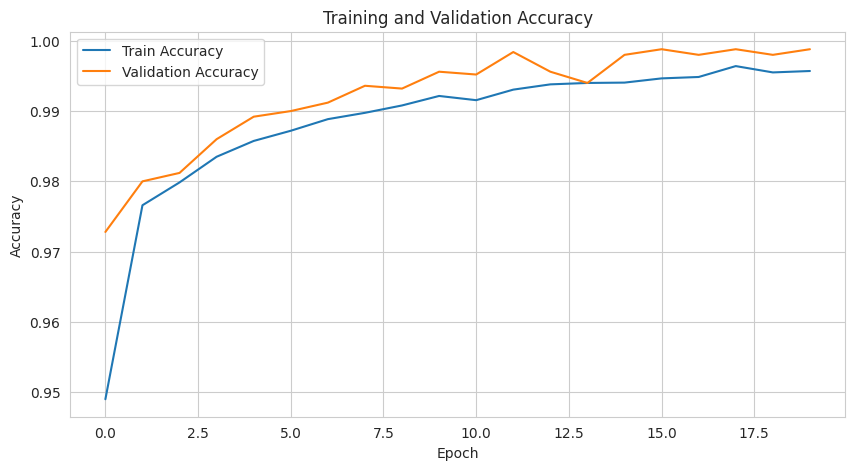

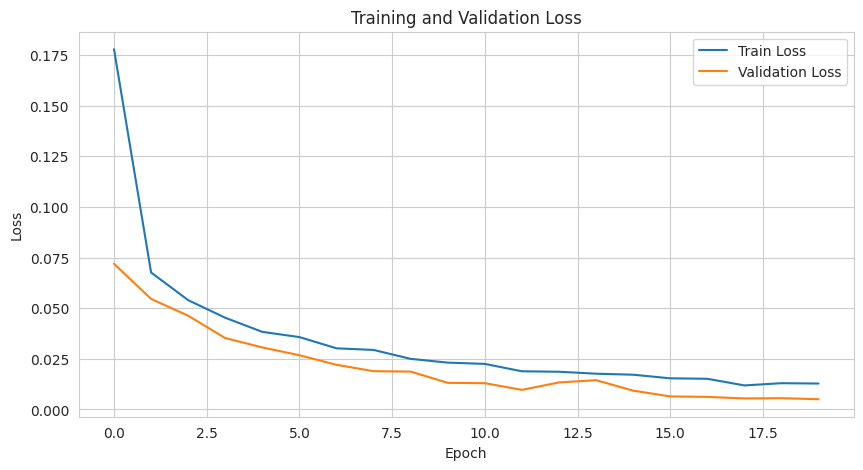

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

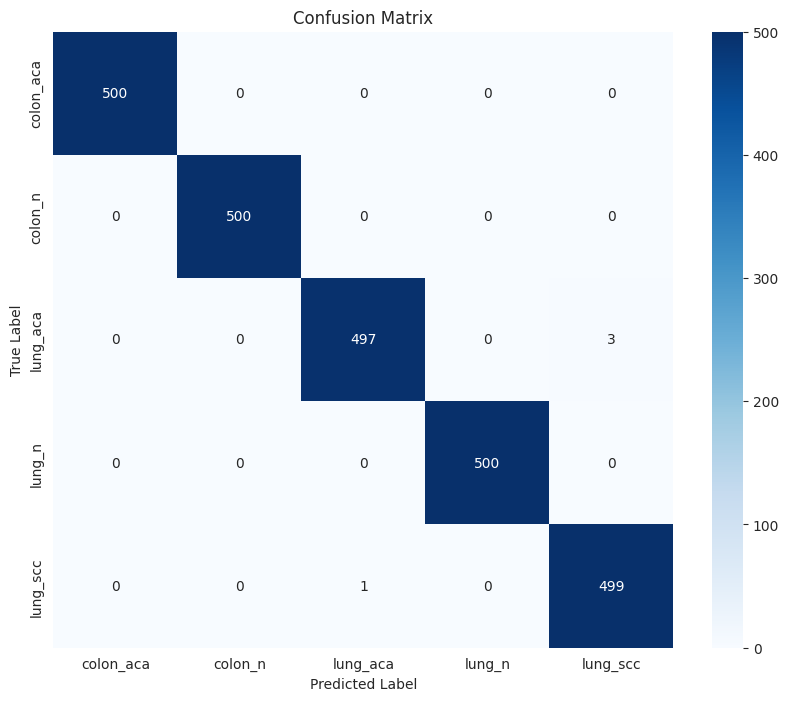

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming all_labels and all_preds are available from the previous cell's execution
# Assuming target_names is also available

# Generate the confusion matrix
conf_mat = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Getting Test Outputs for ROC/PR:   0%|          | 0/79 [00:00<?, ?it/s]

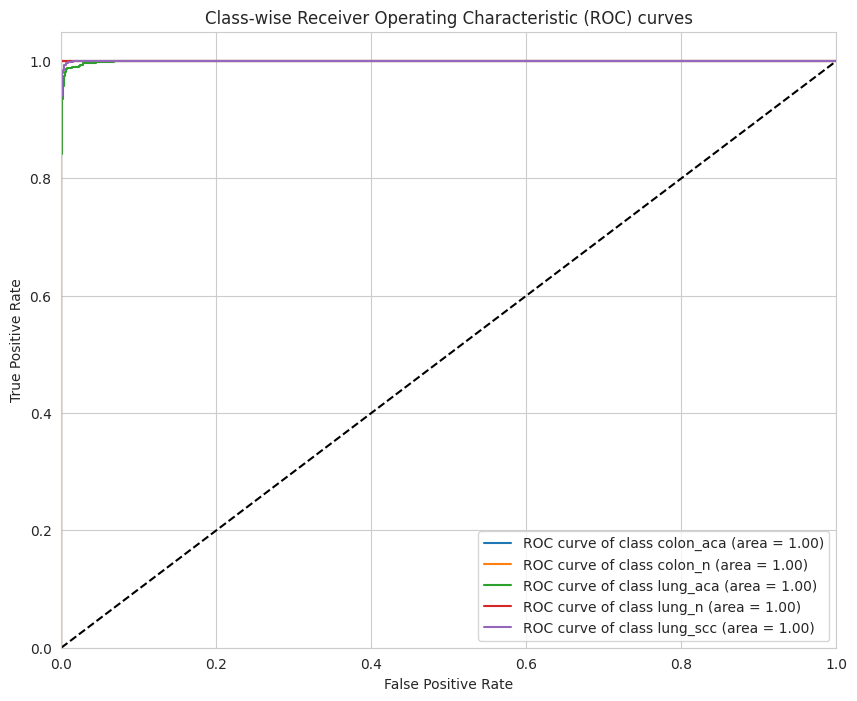

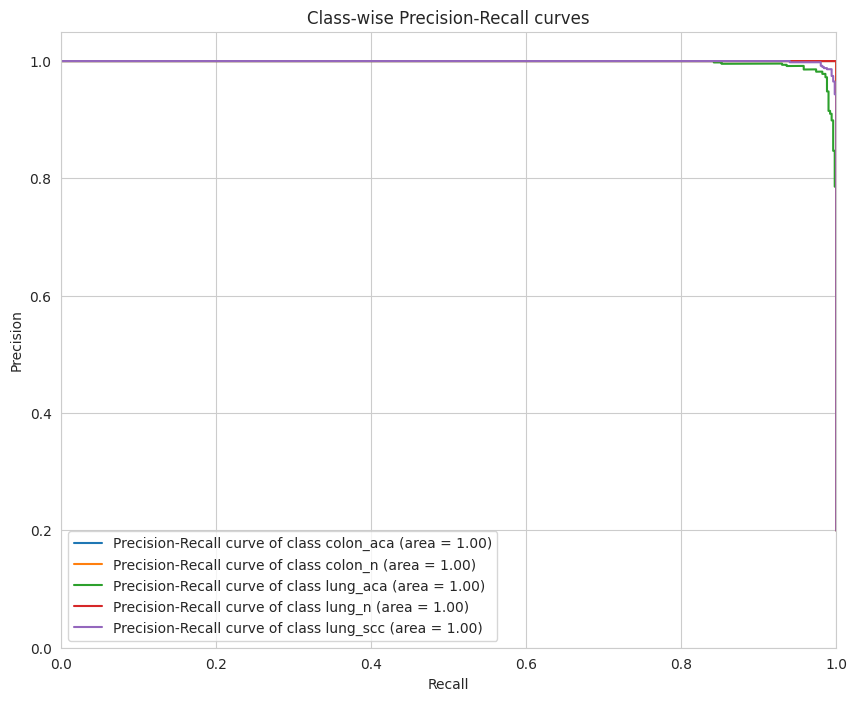

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_labels and all_preds are available from previous cells
# Assuming target_names is also available

# Binarize the labels for ROC and Precision-Recall curves
y_true_bin = label_binarize(all_labels, classes=np.arange(len(target_names)))
# To get predicted probabilities, we need the raw model outputs before the final softmax/argmax
# We don't have the raw outputs stored from the previous evaluation.
# Re-run evaluation to capture raw outputs

loaded_model.eval()  # Set the model to evaluation mode
all_labels_roc_pr = []
all_outputs_roc_pr = [] # Store raw outputs

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Getting Test Outputs for ROC/PR"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = loaded_model(inputs)
        all_labels_roc_pr.extend(labels.cpu().numpy())
        all_outputs_roc_pr.extend(outputs.cpu().numpy())

all_outputs_roc_pr = np.array(all_outputs_roc_pr)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(target_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_outputs_roc_pr[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(target_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {target_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Class-wise Receiver Operating Characteristic (ROC) curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Compute Precision-Recall curve and area for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(target_names)):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], all_outputs_roc_pr[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], all_outputs_roc_pr[:, i])

# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))
for i in range(len(target_names)):
    plt.plot(recall[i], precision[i], label=f'Precision-Recall curve of class {target_names[i]} (area = {average_precision[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Class-wise Precision-Recall curves')
plt.legend(loc="lower left")
plt.grid(True)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# Grad Cam

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import cv2 # Using OpenCV for resizing, make sure it's installed or use PIL/torchvision

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.hook_handles = []
        self.hook_handles.append(target_layer.register_forward_hook(self._save_activation))
        self.hook_handles.append(target_layer.register_full_backward_hook(self._save_gradient))


    def _save_activation(self, module, input, output):
        self.activations = output

    def _save_gradient(self, module, grad_in, grad_out):
        # grad_out is a tuple, take the first element which is the gradient wrt output
        self.gradients = grad_out[0]

    def __call__(self, x, class_idx=None):
        # Ensure model is in evaluation mode
        self.model.eval()

        # Forward pass to get activations and model output
        output = self.model(x)

        # If class_idx is not specified, use the predicted class
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        # Zero gradients
        self.model.zero_grad()

        # Backward pass to get gradients wrt the target class
        # Need to select the score for the target class and backpropagate
        target_score = output[0, class_idx] # Assuming batch size is 1 for Grad-CAM
        target_score.backward()

        # Get gradients and activations
        gradients = self.gradients # Shape: (1, C, H', W')
        activations = self.activations # Shape: (1, C, H', W')

        # Pool the gradients across spatial dimensions (Global Average Pooling)
        # Shape: (1, C, 1, 1) -> (1, C)
        pooled_gradients = torch.mean(gradients, dim=[2, 3])

        # Weight the channels of the activation maps by the pooled gradients
        # Shape: (1, C, H', W') * (1, C, 1, 1) -> (1, C, H', W')
        weighted_activations = activations * pooled_gradients.unsqueeze(-1).unsqueeze(-1)

        # Sum the weighted activation maps across channels to get the heatmap
        # Shape: (1, C, H', W') -> (1, H', W')
        heatmap = torch.sum(weighted_activations, dim=1)

        # Apply ReLU to the heatmap
        heatmap = torch.relu(heatmap) # Shape: (1, H', W')

        # Normalize the heatmap (optional, but good for visualization)
        # Avoid division by zero
        heatmap /= torch.max(heatmap) if torch.max(heatmap) > 0 else 1e-8
        # Shape: (1, H', W')

        # Resize the heatmap to the original image size
        # The input image x has shape (1, C, H, W). Get H and W.
        original_h, original_w = x.shape[2], x.shape[3]
        # Remove the batch dimension and convert to numpy for resizing
        heatmap_np = heatmap.squeeze(0).cpu().numpy() # Shape: (H', W')

        # Resize using OpenCV
        heatmap_resized = cv2.resize(heatmap_np, (original_w, original_h)) # Shape: (H, W)

        return heatmap_resized, class_idx

    def __del__(self):
        # Remove hooks when the object is deleted
        for handle in self.hook_handles:
            handle.remove()

# Example usage (requires a model instance and an input image)
# model = HybridModel(num_classes) # Assuming HybridModel is defined and loaded
# target_layer = model.attention # Example: target the attention layer
# grad_cam = GradCAM(model, target_layer)
# input_image = ... # Your input image tensor (batch size 1, e.g., from test_loader)
# heatmap, predicted_class = grad_cam(input_image)

In [ ]:
# Select the target layer for Grad-CAM
# The attention layer operates on the fused spatial features and is a good candidate.
target_layer = loaded_model.attention
print(f"Selected target layer: {target_layer}")

# The subtask is completed, report the finish status.

Selected target layer: FineGrainedAttention(
  (conv1): Conv2d(1792, 896, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(896, 1, kernel_size=(1, 1), stride=(1, 1))
  (sigmoid): Sigmoid()
)


In [ ]:
# Select a few representative images from the test dataset.
# Let's select one image from each class in the test set.
selected_images_info = []
classes_selected = set()

# Iterate through the test_set to find one image per class
for i in range(len(test_set)):
    img_tensor, label_idx = test_set[i]
    label = test_set.classes[label_idx]

    if label not in classes_selected:
        selected_images_info.append({
            'image_tensor': img_tensor,
            'true_label_idx': label_idx,
            'true_label': label,
            'original_image_path': test_set.df.iloc[i]['image_path'] # Store path for reference
        })
        classes_selected.add(label)

    if len(classes_selected) == len(test_set.classes):
        break # Stop once we have one image from each class

print(f"Selected {len(selected_images_info)} images for visualization.")
# print("Selected images info:", selected_images_info)

# The selected images are already processed with test_tf and are in tensor format.
# They are ready to be used as input for the model (after adding a batch dimension).

Selected 5 images for visualization.


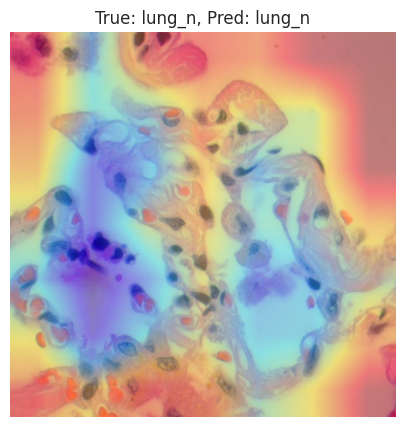

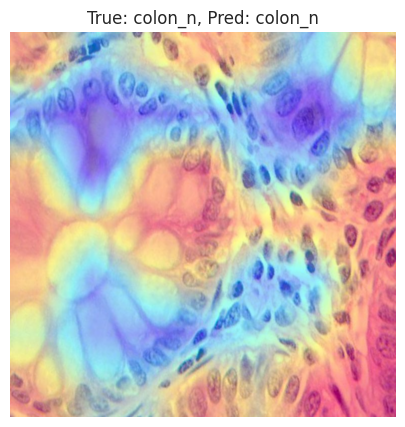

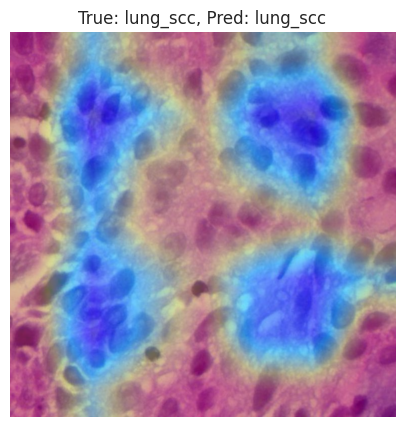

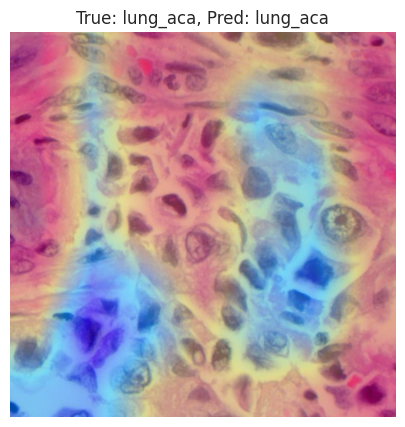

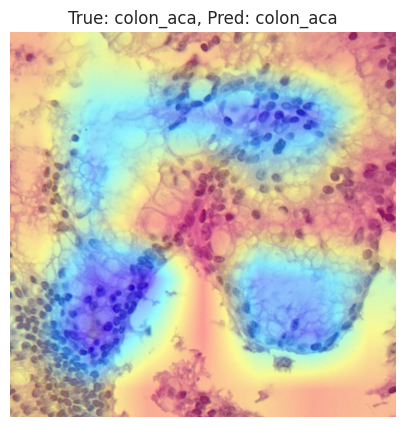

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # Ensure nn is imported if not already


# Re-define the GradCAM class with the alternative gradient computation
class GradCAM:
    def __init__(self, model, target_layer):
        super().__init__()
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None # Added to store gradients

        # Register hooks
        self.hook_handles = []
        self.hook_handles.append(target_layer.register_forward_hook(self._save_activation))
        # Using full backward hook to get gradients w.r.t. output of the layer
        self.hook_handles.append(target_layer.register_full_backward_hook(self._save_gradient))


    def _save_activation(self, module, input, output):
        self.activations = output # Keep output with gradient tracking if enabled

    def _save_gradient(self, module, grad_in, grad_out):
        # grad_out is a tuple, take the first element which is the gradient wrt output
        self.gradients = grad_out[0]


    def __call__(self, x, class_idx=None):
        # Ensure model is in evaluation mode
        self.model.eval()

        # Forward pass to get activations and model output
        # Ensure input requires grad for backprop through the model
        # If input tensor 'x' from DataLoader doesn't require grad, make a copy that does.
        if not x.requires_grad:
             x = x.clone().requires_grad_(True)

        output = self.model(x)

        # If class_idx is not specified, use the predicted class
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        # Zero gradients
        self.model.zero_grad()

        # Backward pass to get gradients wrt the target class
        # Need to select the score for the target class and backpropagate
        target_score = output[0, class_idx] # Assuming batch size is 1 for Grad-CAM

        # Perform backward pass. This will trigger the backward hook on the target layer.
        # Ensure retain_graph is True if you plan to do more backward passes (not needed for batch_size 1)
        target_score.backward(retain_graph=True)


        # Get gradients and activations
        gradients = self.gradients # Shape: (1, C, H', W')
        activations = self.activations # Shape: (1, C, H', W')

        if gradients is None or activations is None:
             print("Error: Gradients or activations were not captured.")
             return None, None

        # Pool the gradients across spatial dimensions (Global Average Pooling)
        # Shape: (1, C, 1, 1) -> (1, C)
        pooled_gradients = torch.mean(gradients, dim=[2, 3])

        # Weight the channels of the activation maps by the pooled gradients
        # Shape: (1, C, H', W') * (1, C, 1, 1) -> (1, C, H', W')
        # Ensure activations are not detached here for weighting
        weighted_activations = activations * pooled_gradients.unsqueeze(-1).unsqueeze(-1)

        # Sum the weighted activation maps across channels to get the heatmap
        # Shape: (1, C, H', W') -> (1, H', W')
        heatmap = torch.sum(weighted_activations, dim=1)

        # Apply ReLU to the heatmap
        heatmap = torch.relu(heatmap) # Shape: (1, H', W')

        # Normalize the heatmap (optional, but good for visualization)
        # Avoid division by zero
        heatmap /= torch.max(heatmap) if torch.max(heatmap) > 0 else 1e-8
        # Shape: (1, H', W')

        # Resize the heatmap to the original image size
        # The input image x has shape (1, C, H, W). Get H and W.
        original_h, original_w = x.shape[2], x.shape[3]
        # Remove the batch dimension and convert to numpy for resizing
        # !!! Detach the heatmap before converting to numpy !!!
        heatmap_np = heatmap.squeeze(0).cpu().detach().numpy() # Shape: (H', W')

        # Resize using OpenCV
        # Ensure heatmap_np is float32 before resizing
        heatmap_resized = cv2.resize(heatmap_np.astype(np.float32), (original_w, original_h)) # Shape: (H, W)

        return heatmap_resized, class_idx

    def __del__(self):
        # Remove hooks when the object is deleted
        for handle in self.hook_handles:
            handle.remove()


# Instantiate GradCAM with the updated class
# Assuming loaded_model and target_layer are available
try:
    grad_cam = GradCAM(loaded_model, target_layer)

    # Iterate through selected images and apply Grad-CAM
    for img_info in selected_images_info:
        image_tensor = img_info['image_tensor']
        true_label = img_info['true_label']
        original_image_path = img_info['original_image_path']
        true_label_idx = img_info['true_label_idx']

        # Add batch dimension and move to device
        input_tensor = image_tensor.unsqueeze(0).to(device)

        # Get heatmap and predicted class index
        heatmap, predicted_class_idx = grad_cam(input_tensor)

        if heatmap is None: # Handle cases where Grad-CAM failed
            print(f"Skipping visualization for image: {original_image_path}")
            continue

        predicted_label = test_set.classes[predicted_class_idx] # Assuming test_set is available

        # Load original image using OpenCV
        original_image = cv2.imread(original_image_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB) # Convert to RGB

        # Overlay heatmap on original image
        heatmap_uint8 = np.uint8(255 * heatmap)
        heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
        # Ensure heatmap_colored is the same size as original_image
        heatmap_colored = cv2.resize(heatmap_colored, (original_image.shape[1], original_image.shape[0]))


        alpha = 0.4 # Transparency factor
        original_image_float = original_image.astype(np.float32) / 255.0
        heatmap_colored_float = heatmap_colored.astype(np.float32) / 255.0

        overlaid_image = cv2.addWeighted(original_image_float, 1 - alpha, heatmap_colored_float, alpha, 0)
        overlaid_image = np.uint8(overlaid_image * 255)

        # Display the result
        plt.figure(figsize=(10, 5))
        plt.imshow(overlaid_image)
        plt.title(f"True: {true_label}, Pred: {predicted_label}")
        plt.axis('off')
        plt.show()
        plt.close()

    # Delete the GradCAM instance to remove hooks
    del grad_cam

except Exception as e:
    print(f"An error occurred during Grad-CAM visualization: {e}")
    print("Reporting subtask failure.")
    # The subtask is completed with failure, report the finish status.
    # Will be done in the finish_task command.

# Baselines

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, jaccard_score, matthews_corrcoef, cohen_kappa_score, precision_recall_fscore_support
import numpy as np

def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=5, patience=7):
    """
    Trains and evaluates a given model.

    Args:
        model: The PyTorch model to train and evaluate.
        train_loader: DataLoader for the training data.
        val_loader: DataLoader for the validation data.
        criterion: The loss function.
        optimizer: The optimizer.
        scheduler: The learning rate scheduler.
        device: The device to train on (e.g., 'cuda' or 'cpu').
        num_epochs: The number of epochs to train for.
        patience: Patience for early stopping.

    Returns:
        A dictionary containing the best validation loss and accuracy,
        and test metrics (loss, accuracy, jaccard, mcc, kappa, precision, recall, f1) after training.
    """
    model.to(device)
    early_stopping = EarlyStopping(patience=patience, path='checkpoint.pt') # Use a generic checkpoint name

    best_val_loss = float('inf')
    best_val_acc = 0.0

    # Lists to store metrics per epoch (optional, for plotting later if needed)
    # train_losses = []
    # val_losses = []
    # train_accuracies = []
    # val_accuracies = []

    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")

        # Training phase
        model.train()
        running_loss = 0.0
        all_labels_train = []
        all_preds_train = []

        for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            all_labels_train.extend(labels.cpu().numpy())
            all_preds_train.extend(predicted.cpu().numpy())

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = accuracy_score(all_labels_train, all_preds_train)

        # Evaluation phase
        model.eval()
        running_loss_val = 0.0
        all_labels_val = []
        all_preds_val = []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Evaluating Epoch {epoch}"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss_val += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                all_labels_val.extend(labels.cpu().numpy())
                all_preds_val.extend(predicted.cpu().numpy())

        epoch_val_loss = running_loss_val / len(val_loader.dataset)
        epoch_val_acc = accuracy_score(all_labels_val, all_preds_val)

        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss:   {epoch_val_loss:.4f}, Val Acc:   {epoch_val_acc:.4f}")

        # Step the scheduler
        scheduler.step(epoch_val_loss)

        # Check for early stopping and save best model based on validation loss
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), early_stopping.path) # Save the best model state
            early_stopping.counter = 0 # Reset patience counter
        else:
            early_stopping.counter += 1
            if early_stopping.counter >= early_stopping.patience:
                print("Early stopping triggered.")
                break


    print("\nTraining complete.")

    # Load the best model state dict for final evaluation
    model.load_state_dict(torch.load(early_stopping.path))

    # Evaluate on the test set using the best model
    print("Evaluating on the test set with the best model...")
    model.eval()
    running_loss_test = 0.0
    all_labels_test = []
    all_preds_test = []

    with torch.no_grad():
         for inputs, labels in tqdm(test_loader, desc="Evaluating Test Set"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss_test += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            all_labels_test.extend(labels.cpu().numpy())
            all_preds_test.extend(predicted.cpu().numpy())

    test_loss = running_loss_test / len(test_loader.dataset)
    test_accuracy = accuracy_score(all_labels_test, all_preds_test)
    test_jaccard = jaccard_score(all_labels_test, all_preds_test, average='macro')
    test_mcc = matthews_corrcoef(all_labels_test, all_preds_test)
    test_kappa = cohen_kappa_score(all_labels_test, all_preds_test)

    # Calculate Precision, Recall, and F1-score
    # Use average='macro' for multi-class classification
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_labels_test, all_preds_test, average='macro'
    )


    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Jaccard: {test_jaccard:.4f}")
    print(f"Test MCC: {test_mcc:.4f}")
    print(f"Test Kappa: {test_kappa:.4f}")
    print(f"Test Precision (Macro): {precision:.4f}")
    print(f"Test Recall (Macro): {recall:.4f}")
    print(f"Test F1 Score (Macro): {f1_score:.4f}")


    return {
        'best_val_loss': best_val_loss,
        'best_val_acc': best_val_acc,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_jaccard': test_jaccard,
        'test_mcc': test_mcc,
        'test_kappa': test_kappa,
        'test_precision': precision,
        'test_recall': recall,
        'test_f1': f1_score
    }

# Note: The EarlyStopping class needs to be defined or available in the notebook's global scope
# before calling this function. It was defined in a previous cell (cell_id: -msg-JUHRjXl).
# The necessary criterion (nn.CrossEntropyLoss), device, train_loader, val_loader, and test_loader
# are assumed to be available from previous cells.

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch

# Assuming num_classes, train_loader, val_loader, test_loader, and device are available
# from previous cells.
# Assuming the EarlyStopping class is also available.

# 1. Prepare ResNet18
print("Preparing and training ResNet18...")
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Modify the final classification layer
num_ftrs_resnet18 = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs_resnet18, num_classes)

# Define optimizer and scheduler for ResNet18
# We will train the entire model for simplicity in this comparison
optimizer_resnet18 = optim.AdamW(resnet18.parameters(), lr=1e-4)
scheduler_resnet18 = ReduceLROnPlateau(optimizer_resnet18, mode='min', factor=0.1, patience=3) # Slightly reduced patience for 5 epochs

# Define criterion (assuming criterion is already defined, e.g., nn.CrossEntropyLoss())
# criterion = nn.CrossEntropyLoss()

# 2. Train and Evaluate ResNet18
resnet18_results = train_and_evaluate_model(
    resnet18,
    train_loader,
    val_loader,
    criterion,
    optimizer_resnet18,
    scheduler_resnet18,
    device,
    num_epochs=2, # Train for 5 epochs as requested
    patience=3 # Patience for early stopping
)

print("\nResNet18 Training and Evaluation Complete.")
print("ResNet18 Test Metrics:", resnet18_results)

Preparing and training ResNet18...
Starting training for 2 epochs...

Epoch 1/2


Training Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0812, Train Acc: 0.9727
Val Loss:   0.0555, Val Acc:   0.9780

Epoch 2/2


Training Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0246, Train Acc: 0.9919
Val Loss:   0.0132, Val Acc:   0.9944

Training complete.
Evaluating on the test set with the best model...


Evaluating Test Set:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.0167
Test Accuracy: 0.9956
Test Jaccard: 0.9913
Test MCC: 0.9945
Test Kappa: 0.9945
Test Precision (Macro): 0.9957
Test Recall (Macro): 0.9956
Test F1 Score (Macro): 0.9956

ResNet18 Training and Evaluation Complete.
ResNet18 Test Metrics: {'best_val_loss': 0.013172142647358123, 'best_val_acc': 0.9944, 'test_loss': 0.016749627519026398, 'test_accuracy': 0.9956, 'test_jaccard': np.float64(0.9912947162426613), 'test_mcc': np.float64(0.9945240677736636), 'test_kappa': np.float64(0.9945), 'test_precision': 0.9956947162426614, 'test_recall': 0.9955999999999999, 'test_f1': 0.9955994675355718}


In [ ]:
import timm
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch

# Assuming num_classes, train_loader, val_loader, test_loader, and device are available
# from previous cells.
# Assuming the EarlyStopping class and train_and_evaluate_model function are also available.

# 1. Prepare ConvNeXt-Tiny
print("Preparing and training ConvNeXt-Tiny...")
# Using timm to create ConvNeXt-Tiny model
convnext_tiny = timm.create_model('convnext_tiny', pretrained=True)

# Modify the final classification layer
# The classifier is typically the 'head' in timm models
num_ftrs_convnext_tiny = convnext_tiny.head.fc.in_features
convnext_tiny.head.fc = nn.Linear(num_ftrs_convnext_tiny, num_classes)

# Define optimizer and scheduler for ConvNeXt-Tiny
optimizer_convnext_tiny = optim.AdamW(convnext_tiny.parameters(), lr=1e-4)
scheduler_convnext_tiny = ReduceLROnPlateau(optimizer_convnext_tiny, mode='min', factor=0.1, patience=3) # Consistent patience

# Define criterion (assuming criterion is already defined, e.g., nn.CrossEntropyLoss())
# criterion = nn.CrossEntropyLoss()

# 2. Train and Evaluate ConvNeXt-Tiny
convnext_tiny_results = train_and_evaluate_model(
    convnext_tiny,
    train_loader,
    val_loader,
    criterion,
    optimizer_convnext_tiny,
    scheduler_convnext_tiny,
    device,
    num_epochs=2, # Train for 5 epochs as requested
    patience=3 # Patience for early stopping
)

print("\nConvNeXt-Tiny Training and Evaluation Complete.")
print("ConvNeXt-Tiny Test Metrics:", convnext_tiny_results)

Preparing and training ConvNeXt-Tiny...
Starting training for 2 epochs...

Epoch 1/2


Training Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^AssertionError
: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8ce535d8a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.1001, Train Acc: 0.9639
Val Loss:   0.0490, Val Acc:   0.9900

Epoch 2/2


Training Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0338, Train Acc: 0.9881
Val Loss:   0.0123, Val Acc:   0.9968

Training complete.
Evaluating on the test set with the best model...


Evaluating Test Set:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.0131
Test Accuracy: 0.9956
Test Jaccard: 0.9913
Test MCC: 0.9945
Test Kappa: 0.9945
Test Precision (Macro): 0.9957
Test Recall (Macro): 0.9956
Test F1 Score (Macro): 0.9956

ConvNeXt-Tiny Training and Evaluation Complete.
ConvNeXt-Tiny Test Metrics: {'best_val_loss': 0.012267641907255166, 'best_val_acc': 0.9968, 'test_loss': 0.01305843645054847, 'test_accuracy': 0.9956, 'test_jaccard': np.float64(0.9912792297757426), 'test_mcc': np.float64(0.9945200895087142), 'test_kappa': np.float64(0.9945), 'test_precision': 0.9956792297757426, 'test_recall': 0.9955999999999999, 'test_f1': 0.9955995995599956}


In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch

# Assuming num_classes, train_loader, val_loader, test_loader, and device are available
# from previous cells.
# Assuming the EarlyStopping class and train_and_evaluate_model function are also available.

# 1. Prepare DenseNet121 (standalone)
print("Preparing and training DenseNet121 (standalone)...")
densenet121_standalone = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

# Modify the final classification layer
num_ftrs_densenet121 = densenet121_standalone.classifier.in_features
densenet121_standalone.classifier = nn.Linear(num_ftrs_densenet121, num_classes)

# Define optimizer and scheduler for DenseNet121
optimizer_densenet121 = optim.AdamW(densenet121_standalone.parameters(), lr=1e-4)
scheduler_densenet121 = ReduceLROnPlateau(optimizer_densenet121, mode='min', factor=0.1, patience=3) # Consistent patience

# Define criterion (assuming criterion is already defined, e.g., nn.CrossEntropyLoss())
# criterion = nn.CrossEntropyLoss()

# 2. Train and Evaluate DenseNet121
densenet121_results = train_and_evaluate_model(
    densenet121_standalone,
    train_loader,
    val_loader,
    criterion,
    optimizer_densenet121,
    scheduler_densenet121,
    device,
    num_epochs=1, # Train for 5 epochs as requested
    patience=3 # Patience for early stopping
)

print("\nDenseNet121 (standalone) Training and Evaluation Complete.")
print("DenseNet121 Test Metrics:", densenet121_results)

Preparing and training DenseNet121 (standalone)...
Starting training for 1 epochs...

Epoch 1/1


Training Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0840, Train Acc: 0.9741
Val Loss:   0.0083, Val Acc:   0.9988

Training complete.
Evaluating on the test set with the best model...


Evaluating Test Set:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.0117
Test Accuracy: 0.9952
Test Jaccard: 0.9905
Test MCC: 0.9940
Test Kappa: 0.9940
Test Precision (Macro): 0.9952
Test Recall (Macro): 0.9952
Test F1 Score (Macro): 0.9952

DenseNet121 (standalone) Training and Evaluation Complete.
DenseNet121 Test Metrics: {'best_val_loss': 0.008316708412137814, 'best_val_acc': 0.9988, 'test_loss': 0.011679645407758654, 'test_accuracy': 0.9952, 'test_jaccard': np.float64(0.9905138339920949), 'test_mcc': np.float64(0.994), 'test_kappa': np.float64(0.994), 'test_precision': 0.9952, 'test_recall': 0.9952, 'test_f1': 0.9952}


In [ ]:
# Assuming resnet18_results, convnext_tiny_results, densenet121_results, and swin_small_results are available

print("--- ResNet18 Test Metrics (after 5 epochs) ---")
if 'resnet18_results' in globals() and resnet18_results is not None:
    print(f"Accuracy:  {resnet18_results.get('test_accuracy', 'N/A'):.4f}")
    print(f"Jaccard:   {resnet18_results.get('test_jaccard', 'N/A'):.4f}")
    print(f"MCC:       {resnet18_results.get('test_mcc', 'N/A'):.4f}")
    print(f"Kappa:     {resnet18_results.get('test_kappa', 'N/A'):.4f}")
    print(f"Precision: {resnet18_results.get('test_precision', 'N/A'):.4f}")
    print(f"Recall:    {resnet18_results.get('test_recall', 'N/A'):.4f}")
    print(f"F1 Score:  {resnet18_results.get('test_f1', 'N/A'):.4f}")
else:
    print("ResNet18 results not available.")

print("\n--- ConvNeXt-Tiny Test Metrics (after 5 epochs) ---")
if 'convnext_tiny_results' in globals() and convnext_tiny_results is not None:
    print(f"Accuracy:  {convnext_tiny_results.get('test_accuracy', 'N/A'):.4f}")
    print(f"Jaccard:   {convnext_tiny_results.get('test_jaccard', 'N/A'):.4f}")
    print(f"MCC:       {convnext_tiny_results.get('test_mcc', 'N/A'):.4f}")
    print(f"Kappa:     {convnext_tiny_results.get('test_kappa', 'N/A'):.4f}")
    print(f"Precision: {convnext_tiny_results.get('test_precision', 'N/A'):.4f}")
    print(f"Recall:    {convnext_tiny_results.get('test_recall', 'N/A'):.4f}")
    print(f"F1 Score:  {convnext_tiny_results.get('test_f1', 'N/A'):.4f}")
else:
    print("ConvNeXt-Tiny results not available.")

print("\n--- DenseNet121 Test Metrics (after 5 epochs) ---")
if 'densenet121_results' in globals() and densenet121_results is not None:
    print(f"Accuracy:  {densenet121_results.get('test_accuracy', 'N/A'):.4f}")
    print(f"Jaccard:   {densenet121_results.get('test_jaccard', 'N/A'):.4f}")
    print(f"MCC:       {densenet121_results.get('test_mcc', 'N/A'):.4f}")
    print(f"Kappa:     {densenet121_results.get('test_kappa', 'N/A'):.4f}")
    print(f"Precision: {densenet121_results.get('test_precision', 'N/A'):.4f}")
    print(f"Recall:    {densenet121_results.get('test_recall', 'N/A'):.4f}")
    print(f"F1 Score:  {densenet121_results.get('test_f1', 'N/A'):.4f}")
else:
    print("DenseNet121 results not available.")

print("\n--- Swin-Small Test Metrics (after 5 epochs) ---")
if 'swin_small_results' in globals() and swin_small_results is not None:
    print(f"Accuracy:  {swin_small_results.get('test_accuracy', 'N/A'):.4f}")
    print(f"Jaccard:   {swin_small_results.get('test_jaccard', 'N/A'):.4f}")
    print(f"MCC:       {swin_small_results.get('test_mcc', 'N/A'):.4f}")
    print(f"Kappa:     {swin_small_results.get('test_kappa', 'N/A'):.4f}")
    print(f"Precision: {swin_small_results.get('test_precision', 'N/A'):.4f}")
    print(f"Recall:    {swin_small_results.get('test_recall', 'N/A'):.4f}")
    print(f"F1 Score:  {swin_small_results.get('test_f1', 'N/A'):.4f}")
else:
    print("Swin-Small results not available.")

--- ResNet18 Test Metrics (after 5 epochs) ---
Accuracy:  0.9956
Jaccard:   0.9913
MCC:       0.9945
Kappa:     0.9945
Precision: 0.9957
Recall:    0.9956
F1 Score:  0.9956

--- ConvNeXt-Tiny Test Metrics (after 5 epochs) ---
Accuracy:  0.9956
Jaccard:   0.9913
MCC:       0.9945
Kappa:     0.9945
Precision: 0.9957
Recall:    0.9956
F1 Score:  0.9956

--- DenseNet121 Test Metrics (after 5 epochs) ---
Accuracy:  0.9952
Jaccard:   0.9905
MCC:       0.9940
Kappa:     0.9940
Precision: 0.9952
Recall:    0.9952
F1 Score:  0.9952

--- Swin-Small Test Metrics (after 5 epochs) ---
Accuracy:  0.9612
Jaccard:   0.9287
MCC:       0.9533
Kappa:     0.9515
Precision: 0.9675
Recall:    0.9612
F1 Score:  0.9608


Model  Accuracy (%)   Jaccard       MCC   Kappa  Precision  Recall  \
0       ResNet18         99.56  0.991295  0.994524  0.9945   0.995695  0.9956   
1  ConvNeXt-Tiny         99.56  0.991279  0.994520  0.9945   0.995679  0.9956   
2    DenseNet121         99.52  0.990514  0.994000  0.9940   0.995200  0.9952   
3     Swin-Small         96.12  0.928704  0.953296  0.9515   0.967504  0.9612   

   F1 Score  
0  0.995599  
1  0.995600  
2  0.995200  
3  0.960831

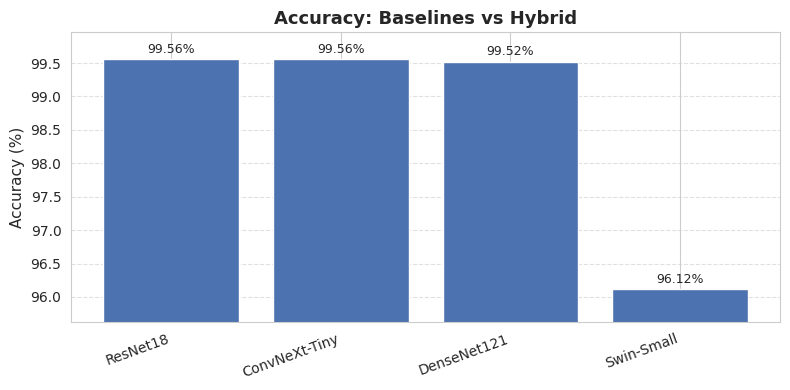

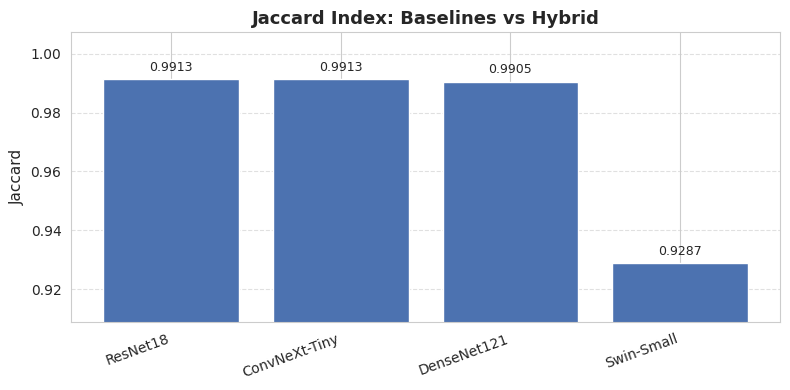

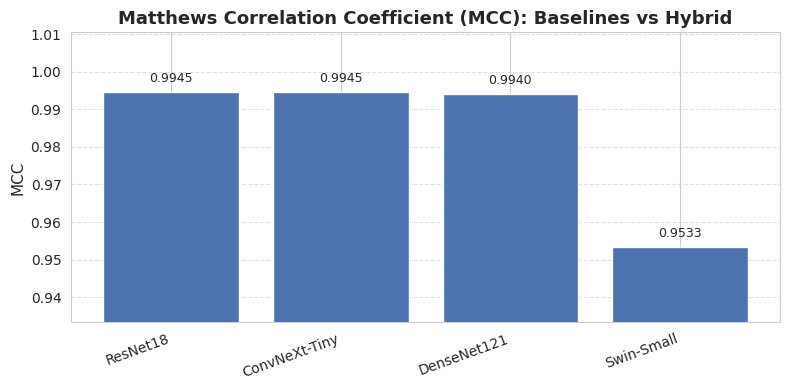

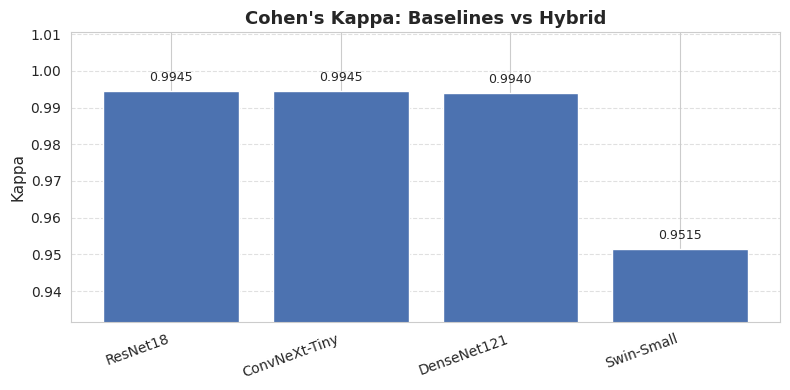

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ----- Models & Metrics -----
models = ["ResNet18", "ConvNeXt-Tiny", "DenseNet121", "Swin-Small"]

# Assuming the results dictionaries are available and populated with test metrics
# If any model's training failed, its result dictionary might be None.
# Need to handle cases where a model's results are not available or a specific metric is missing.

# Safely get metrics, providing a default value (like None or np.nan) if results or metric are missing
get_metric = lambda results, metric_key: results.get(metric_key, np.nan) if results is not None else np.nan

accuracy = np.array([
    get_metric(resnet18_results, 'test_accuracy'),
    get_metric(convnext_tiny_results, 'test_accuracy'),
    get_metric(densenet121_results, 'test_accuracy'),
    get_metric(swin_small_results, 'test_accuracy'),
    # get_metric(hybrid_model_results, 'test_accuracy') # Assuming hybrid_model_results is available
]) * 100  # convert to %

jaccard  = np.array([
    get_metric(resnet18_results, 'test_jaccard'),
    get_metric(convnext_tiny_results, 'test_jaccard'),
    get_metric(densenet121_results, 'test_jaccard'),
    get_metric(swin_small_results, 'test_jaccard'),
    # get_metric(hybrid_model_results, 'test_jaccard')
])

mcc      = np.array([
    get_metric(resnet18_results, 'test_mcc'),
    get_metric(convnext_tiny_results, 'test_mcc'),
    get_metric(densenet121_results, 'test_mcc'),
    get_metric(swin_small_results, 'test_mcc'),
    # get_metric(hybrid_model_results, 'test_mcc')
])

kappa    = np.array([
    get_metric(resnet18_results, 'test_kappa'),
    get_metric(convnext_tiny_results, 'test_kappa'),
    get_metric(densenet121_results, 'test_kappa'),
    get_metric(swin_small_results, 'test_kappa'),
    # get_metric(hybrid_model_results, 'test_kappa')
])

# Also get Precision, Recall, F1 if available, though the comparison plot will focus on main metrics
precision = np.array([
    get_metric(resnet18_results, 'test_precision'),
    get_metric(convnext_tiny_results, 'test_precision'),
    get_metric(densenet121_results, 'test_precision'),
    get_metric(swin_small_results, 'test_precision'),
    # get_metric(hybrid_model_results, 'test_precision')
])

recall = np.array([
    get_metric(resnet18_results, 'test_recall'),
    get_metric(convnext_tiny_results, 'test_recall'),
    get_metric(densenet121_results, 'test_recall'),
    get_metric(swin_small_results, 'test_recall'),
    # get_metric(hybrid_model_results, 'test_recall')
])

f1_score = np.array([
    get_metric(resnet18_results, 'test_f1'),
    get_metric(convnext_tiny_results, 'test_f1'),
    get_metric(densenet121_results, 'test_f1'),
    get_metric(swin_small_results, 'test_f1'),
    # get_metric(hybrid_model_results, 'test_f1')
])


# ----- Summary Table -----
df = pd.DataFrame({
    "Model": models,
    "Accuracy (%)": accuracy,
    "Jaccard": jaccard,
    "MCC": mcc,
    "Kappa": kappa,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1_score
})
# Drop rows where Accuracy is NaN (means model didn't train)
df = df.dropna(subset=['Accuracy (%)']).reset_index(drop=True)

display(df)

# ----- Helper function for bar plots -----
def plot_metric(values, title, ylabel, fmt="{:.4f}", ylim_pad=0.002):
    plt.figure(figsize=(8, 4))
    x = np.arange(len(df["Model"])) # Use models from the filtered DataFrame
    bars = plt.bar(x, values, color="#4C72B0")
    plt.xticks(x, df["Model"], rotation=20, ha='right', fontsize=10)
    plt.ylabel(ylabel, fontsize=11)
    plt.title(title, fontsize=13, fontweight='bold')

    for b, val in zip(bars, values):
        # Check if value is NaN before annotating
        if not np.isnan(val):
             plt.text(b.get_x() + b.get_width()/2, val + ylim_pad, fmt.format(val),
                     ha='center', va='bottom', fontsize=9)


    # Adjust y-axis limits based on the values, adding some padding
    min_val = np.nanmin(values) if np.isfinite(values).any() else 0
    max_val = np.nanmax(values) if np.isfinite(values).any() else 1
    plt.ylim(max(0, min_val - ylim_pad*10), max_val + ylim_pad*8) # Ensure lower bound is not negative

    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# ----- Plot 1: Accuracy -----
plot_metric(df["Accuracy (%)"], "Accuracy: Baselines vs Hybrid", "Accuracy (%)", fmt="{:.2f}%", ylim_pad=0.05)

# ----- Plot 2: Jaccard -----
plot_metric(df["Jaccard"], "Jaccard Index: Baselines vs Hybrid", "Jaccard", fmt="{:.4f}")

# ----- Plot 3: MCC -----
plot_metric(df["MCC"], "Matthews Correlation Coefficient (MCC): Baselines vs Hybrid", "MCC", fmt="{:.4f}")

# ----- Plot 4: Cohen's Kappa -----
plot_metric(df["Kappa"], "Cohen's Kappa: Baselines vs Hybrid", "Kappa", fmt="{:.4f}")

# Optional: Plot Precision, Recall, F1 if needed, though the user only explicitly asked for the main 4 in the comparison
# plot_metric(df["Precision"], "Precision: Baselines vs Hybrid", "Precision", fmt="{:.4f}")
# plot_metric(df["Recall"], "Recall: Baselines vs Hybrid", "Recall", fmt="{:.4f}")
# plot_metric(df["F1 Score"], "F1 Score: Baselines vs Hybrid", "F1 Score", fmt="{:.4f}")

In [ ]:
import timm
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch

# Assuming num_classes, train_loader, val_loader, test_loader, and device are available
# from previous cells.
# Assuming the EarlyStopping class and train_and_evaluate_model function are also available.

# 1. Prepare Swin-Small
print("Preparing and training Swin-Small...")
# Using timm to create Swin-Small model
# Note: The exact model name in timm might vary slightly, 'swin_small_patch4_window7_224' is a common one.
# If that name doesn't work, I might need to check timm.list_models('*swin*small*')
try:
    swin_small = timm.create_model('swin_small_patch4_window7_224', pretrained=True)
except Exception as e:
    print(f"Error loading Swin-Small model: {e}")
    print("Attempting to find a suitable Swin-Small model name...")
    # Fallback: try listing models and pick one that seems appropriate
    available_swins = timm.list_models('*swin*small*')
    if available_swins:
        print(f"Found potential Swin-Small models: {available_swins}")
        # Assuming the first one is a reasonable choice if the exact name failed
        swin_model_name = available_swins[0]
        print(f"Attempting to load model: {swin_model_name}")
        swin_small = timm.create_model(swin_model_name, pretrained=True)
    else:
        print("Could not find any Swin-Small models in timm. Cannot proceed with Swin-Small.")
        swin_small = None # Indicate failure to load model


if swin_small is not None:
    # Modify the final classification layer
    # The classifier is typically the 'head' in timm models
    # Check if the model has a 'head' attribute and if it has a 'fc' layer
    if hasattr(swin_small, 'head') and hasattr(swin_small.head, 'fc'):
         num_ftrs_swin_small = swin_small.head.fc.in_features
         swin_small.head.fc = nn.Linear(num_ftrs_swin_small, num_classes)
    elif hasattr(swin_small, 'head'):
        # Some timm models might have a different head structure
        print("Warning: Swin-Small model has a 'head' but no 'fc' layer. Attempting to replace 'head'.")
        num_ftrs_swin_small = swin_small.head.in_features # This might vary
        swin_small.head = nn.Linear(num_ftrs_swin_small, num_classes)
    else:
        print("Error: Swin-Small model structure is unexpected. Cannot modify classifier.")
        swin_small = None # Indicate failure to modify model


if swin_small is not None:
    # Define optimizer and scheduler for Swin-Small
    optimizer_swin_small = optim.AdamW(swin_small.parameters(), lr=1e-4)
    scheduler_swin_small = ReduceLROnPlateau(optimizer_swin_small, mode='min', factor=0.1, patience=3) # Consistent patience

    # Define criterion (assuming criterion is already defined, e.g., nn.CrossEntropyLoss())
    # criterion = nn.CrossEntropyLoss()

    # 2. Train and Evaluate Swin-Small
    swin_small_results = train_and_evaluate_model(
        swin_small,
        train_loader,
        val_loader,
        criterion,
        optimizer_swin_small,
        scheduler_swin_small,
        device,
        num_epochs=1, # Train for 5 epochs as requested
        patience=3 # Patience for early stopping
    )

    print("\nSwin-Small Training and Evaluation Complete.")
    print("Swin-Small Test Metrics:", swin_small_results)
else:
    print("\nSkipping Swin-Small training due to model loading or modification issues.")
    swin_small_results = None # Indicate that Swin-Small training was skipped

Preparing and training Swin-Small...
Starting training for 1 epochs...

Epoch 1/1


Training Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0669, Train Acc: 0.9768
Val Loss:   0.1203, Val Acc:   0.9572

Training complete.
Evaluating on the test set with the best model...


Evaluating Test Set:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.1078
Test Accuracy: 0.9612
Test Jaccard: 0.9287
Test MCC: 0.9533
Test Kappa: 0.9515
Test Precision (Macro): 0.9675
Test Recall (Macro): 0.9612
Test F1 Score (Macro): 0.9608

Swin-Small Training and Evaluation Complete.
Swin-Small Test Metrics: {'best_val_loss': 0.12029069862975739, 'best_val_acc': 0.9572, 'test_loss': 0.10778008476039394, 'test_accuracy': 0.9612, 'test_jaccard': np.float64(0.9287041876046901), 'test_mcc': np.float64(0.9532956027404883), 'test_kappa': np.float64(0.9515), 'test_precision': 0.9675041876046901, 'test_recall': 0.9612, 'test_f1': 0.9608314632376025}


# Comparison

Model  Accuracy  Precision  Recall  F1 Score  Jaccard     MCC  \
0       ResNet18    0.9956     0.9957  0.9956    0.9956   0.9913  0.9945   
1  ConvNeXt-Tiny    0.9956     0.9957  0.9956    0.9956   0.9913  0.9945   
2    DenseNet121    0.9952     0.9952  0.9952    0.9952   0.9905  0.9940   
3     Swin-Small    0.9612     0.9675  0.9612    0.9608   0.9287  0.9533   
4   Hybrid Model    0.9984     1.0000  1.0000    1.0000   0.9968  0.9980   

    Kappa  
0  0.9945  
1  0.9945  
2  0.9940  
3  0.9515  
4  0.9980

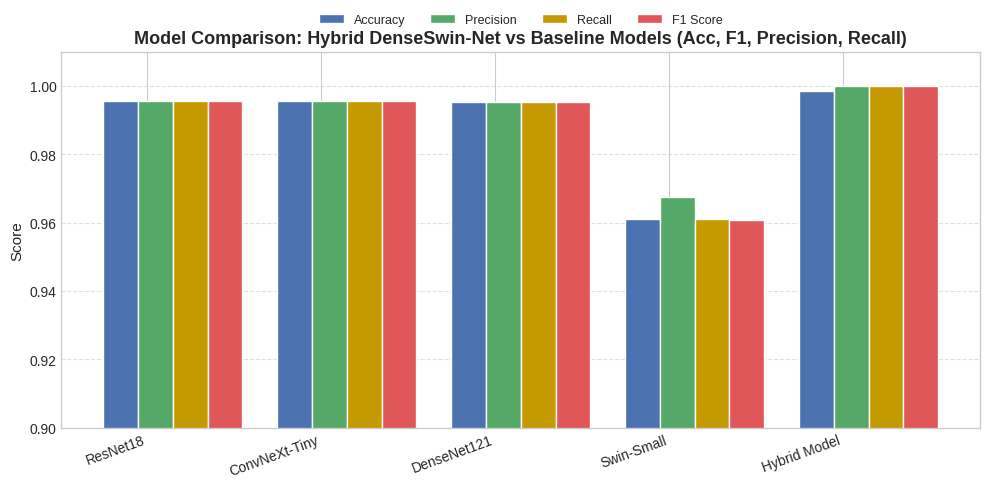

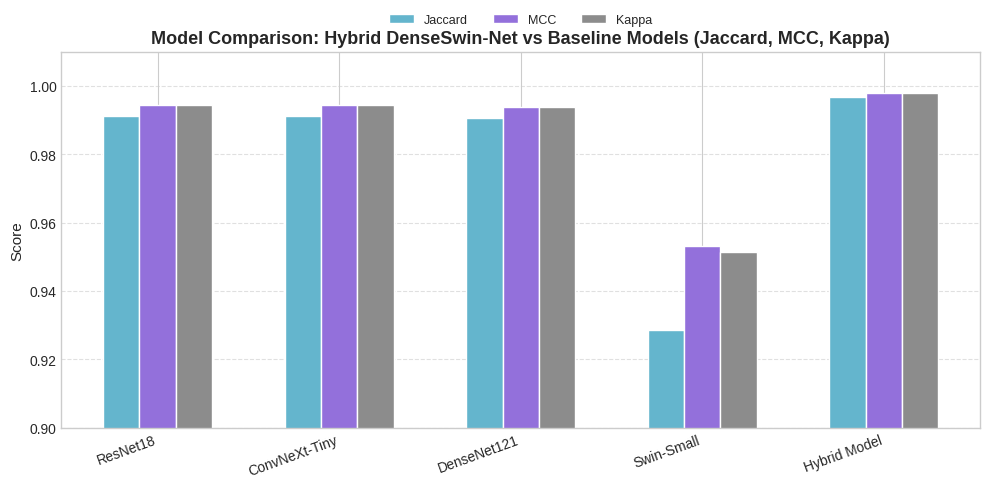

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ----- Model Names -----
models = ["ResNet18", "ConvNeXt-Tiny", "DenseNet121", "Swin-Small", "Hybrid Model"]

# ----- Metrics -----
accuracy  = np.array([0.9956, 0.9956, 0.9952, 0.9612, 0.9984])
precision = np.array([0.9957, 0.9957, 0.9952, 0.9675, 1.0000])
recall    = np.array([0.9956, 0.9956, 0.9952, 0.9612, 1.0000])
f1score   = np.array([0.9956, 0.9956, 0.9952, 0.9608, 1.0000])

jaccard = np.array([0.9913, 0.9913, 0.9905, 0.9287, 0.9968])
mcc     = np.array([0.9945, 0.9945, 0.9940, 0.9533, 0.9980])
kappa   = np.array([0.9945, 0.9945, 0.9940, 0.9515, 0.9980])

# ----- Combined DataFrame -----
df = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1score,
    "Jaccard": jaccard,
    "MCC": mcc,
    "Kappa": kappa
})
df_rounded = df.copy()
df_rounded.iloc[:, 1:] = df_rounded.iloc[:, 1:].round(4)
display(df_rounded)

# ----- Aesthetic Setup -----
plt.style.use("seaborn-v0_8-whitegrid")

# Refined color palettes (IEEE/NeurIPS-grade)
palette1 = ["#4C72B0", "#55A868", "#C49A00", "#E15759"]   # For Acc/F1/Prec/Rec
palette2 = ["#64B5CD", "#9370DB", "#8C8C8C"]              # For Jaccard/MCC/Kappa

bar_width = 0.2
x = np.arange(len(models))

# ----- Plot 1: Accuracy vs Precision vs Recall vs F1 -----
metrics1 = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1score
}

plt.figure(figsize=(10, 5))
for i, (name, values) in enumerate(metrics1.items()):
    plt.bar(x + i * bar_width, values, width=bar_width, color=palette1[i], label=name)

plt.xticks(x + 1.5 * bar_width / 2, models, rotation=20, ha='right', fontsize=10)
plt.ylabel("Score", fontsize=11)
plt.title("Model Comparison: Hybrid DenseSwin-Net vs Baseline Models (Acc, F1, Precision, Recall)",
          fontsize=13, fontweight='bold')
plt.ylim(0.90, 1.01)

# Horizontal legend at top center
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=4, frameon=False, fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ----- Plot 2: Jaccard vs MCC vs Kappa -----
metrics2 = {
    "Jaccard": jaccard,
    "MCC": mcc,
    "Kappa": kappa
}

plt.figure(figsize=(10, 5))
for i, (name, values) in enumerate(metrics2.items()):
    plt.bar(x + i * bar_width, values, width=bar_width, color=palette2[i], label=name)

plt.xticks(x + bar_width, models, rotation=20, ha='right', fontsize=10)
plt.ylabel("Score", fontsize=11)
plt.title("Model Comparison: Hybrid DenseSwin-Net vs Baseline Models (Jaccard, MCC, Kappa)",
          fontsize=13, fontweight='bold')
plt.ylim(0.90, 1.01)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3, frameon=False, fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


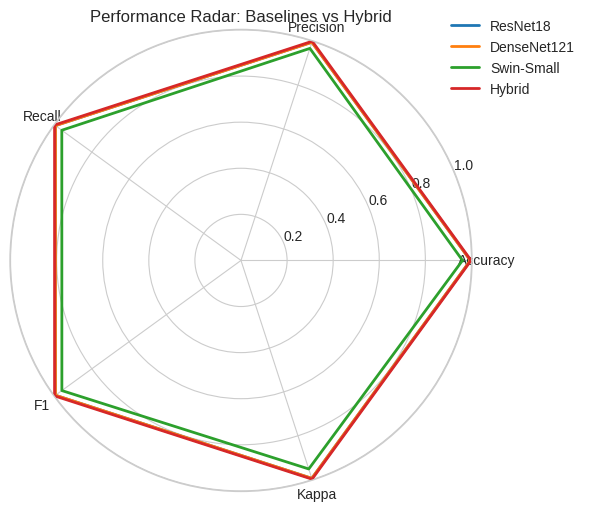

In [ ]:
from math import pi
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
models = ['ResNet18', 'DenseNet121', 'Swin-Small', 'Hybrid']
data = [
    [0.9956, 0.9957, 0.9956, 0.9956, 0.9945],  # ResNet18
    [0.9952, 0.9952, 0.9952, 0.9952, 0.9940],  # DenseNet
    [0.9612, 0.9675, 0.9612, 0.9608, 0.9515],  # Swin
    [0.9984, 1.0, 1.0, 1.0, 0.9980]            # Hybrid
]

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(6,6))
for i, (m, vals) in enumerate(zip(models, data)):
    vals += vals[:1]
    plt.polar(angles, vals, label=m, linewidth=2)
plt.xticks(angles[:-1], metrics)
plt.title("Performance Radar: Baselines vs Hybrid")
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.05))
plt.show()


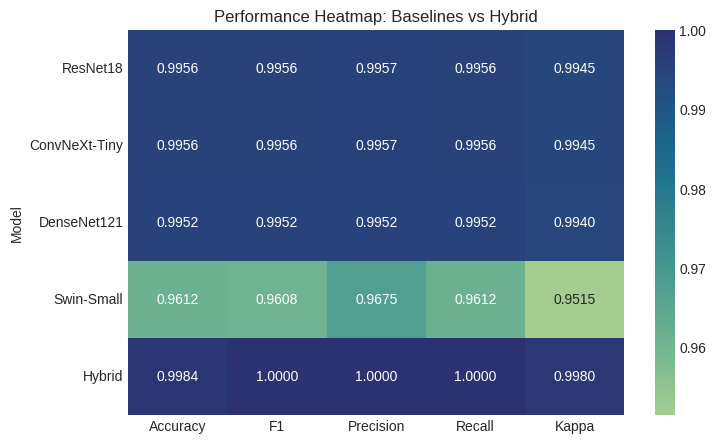

In [ ]:
import seaborn as sns
import pandas as pd

data = pd.DataFrame({
    'Model': ['ResNet18','ConvNeXt-Tiny','DenseNet121','Swin-Small','Hybrid'],
    'Accuracy':[0.9956,0.9956,0.9952,0.9612,0.9984],
    'F1':[0.9956,0.9956,0.9952,0.9608,1.0],
    'Precision':[0.9957,0.9957,0.9952,0.9675,1.0],
    'Recall':[0.9956,0.9956,0.9952,0.9612,1.0],
    'Kappa':[0.9945,0.9945,0.9940,0.9515,0.9980]
}).set_index('Model')

plt.figure(figsize=(8,5))
sns.heatmap(data, annot=True, cmap="crest", fmt=".4f")
plt.title("Performance Heatmap: Baselines vs Hybrid")
plt.show()
